In [ ]:
# import all the libraries
import numpy as np
import argparse
import time
from random import shuffle
import random
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.regularizers import l1,l2
from tensorflow.keras.optimizers import Adam

In [ ]:
# connect to google drive
from google.colab import drive
drive.mount('/content/myDrive/')

Mounted at /content/myDrive/


In [ ]:
# go to folder with /data and /utils
cd myDrive/MyDrive/ZSL

/content/myDrive/MyDrive/ZSL


In [ ]:
# set device as GPU
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Zero shot learning - final project
## DL for Spiking Neural Networks and Advanced Data Mining

In [ ]:
from scipy import io
att_splits=io.loadmat('./data/AWA2/binaryAtt_splits.mat')
# retrieve all the class names
classes_names = [a[0] for a in np.squeeze(att_splits['allclasses_names'])]
# create helper dictionary from class id to class name
id_to_name = {i:name for (i,name) in enumerate(classes_names)}

### Reading data

In [ ]:
from utils import data_loader
import importlib
# load /utils/data_loader
importlib.reload(data_loader)
# load the data
trainDataX, trainDataLabels, trainDataAttrs, testDataX, testDataLabels, testDataAttrs = data_loader.DataLoader("./data/CUB", binary=False).load()
trainDataX = (trainDataX - np.mean(trainDataX)) / np.std(trainDataX) # normalize image embeddings
testDataX = (testDataX - np.mean(testDataX)) / np.std(testDataX) # normalize image embeddings

# get the number of testing examples
test_size = len(testDataLabels)

In [ ]:
# check total number of classes (test & train)
num_classes = len(np.unique(np.concatenate((trainDataLabels, testDataLabels))))
num_classes

50

### Prepare input shape

In [ ]:
# prepare the input tensor for the model
in_shape = trainDataX.shape[1]
inputs = Input(shape=(in_shape,))


### Define useful for evaluation dictionaries

In [ ]:
# create class_id:attribute dictionary
class_attr_dict = {}
for A, B in zip(trainDataLabels, trainDataAttrs):
    # training classes
    class_attr_dict[A] = B
for A, B in zip(testDataLabels, testDataAttrs):
    # testing classes
    class_attr_dict[A] = B

# sort it from smallest to highest id
keys = sorted(class_attr_dict)
class_attr_dict = {i: class_attr_dict[i] for i in keys}
class_attr_dict.keys()

# create dictionary from attributes to a class id
atrr_to_class = {v.tobytes(): k for k, v in class_attr_dict.items()}
all_class_atrs = class_attr_dict.values()


In [ ]:
# create class_id:attribute dictionary for test classes
test_attributes = {}
for A, B in zip(testDataLabels, testDataAttrs):
    test_attributes[A] = B
test_attributes = test_attributes.values()

# Models creation

_____________________

### Model 1

In [ ]:
x = Dropout(0.5)(inputs) # 0.5 dropout
# create 85 attribute classifiers
attribute_classifiers = []
for p in range(85):
        # use sigmoid to get probability
        single_classifier = Dense(1, activation='sigmoid',
                activity_regularizer=l1(0.01))(x) # use regularization
        attribute_classifiers.append(single_classifier)

model1 = Model(inputs, attribute_classifiers)

with tf.device(device_name): # on gpu
  model1.compile(optimizer=Adam(learning_rate=0.001), loss=['binary_crossentropy']*85, metrics=['accuracy'])

hist1 = model1.fit(trainDataX, list(trainDataAttrs.T), batch_size=64, shuffle=True, epochs=10, callbacks=[EarlyStopping(monitor='loss',min_delta=0.0001, patience=2)])


Epoch 1/10
460/460 [==============================] - 107s 109ms/step - loss: 15.9471 - dense_loss: 0.3638 - dense_1_loss: 0.3143 - dense_2_loss: 0.0720 - dense_3_loss: 0.2698 - dense_4_loss: 0.2945 - dense_5_loss: 0.0803 - dense_6_loss: 0.0465 - dense_7_loss: 0.0724 - dense_8_loss: 0.3717 - dense_9_loss: 0.2821 - dense_10_loss: 0.0943 - dense_11_loss: 0.1125 - dense_12_loss: 0.1565 - dense_13_loss: 0.2194 - dense_14_loss: 0.1399 - dense_15_loss: 0.1831 - dense_16_loss: 0.2538 - dense_17_loss: 0.2989 - dense_18_loss: 0.0792 - dense_19_loss: 0.0576 - dense_20_loss: 0.1677 - dense_21_loss: 0.2521 - dense_22_loss: 0.1568 - dense_23_loss: 0.2476 - dense_24_loss: 0.1400 - dense_25_loss: 0.1873 - dense_26_loss: 0.1927 - dense_27_loss: 0.2243 - dense_28_loss: 0.1433 - dense_29_loss: 0.0737 - dense_30_loss: 0.1509 - dense_31_loss: 0.2089 - dense_32_loss: 0.0636 - dense_33_loss: 0.3287 - dense_34_loss: 0.0234 - dense_35_loss: 0.0809 - dense_36_loss: 0.0963 - dense_37_loss: 0.0701 - dense_38_los

_______________________________________
### Model 2

In [ ]:
# no dropout
attribute_classifiers = []
# create 85 attribute classifiers
attribute_classifiers = []
for p in range(85):
        # use sigmoid to get probability
        single_classifier = Dense(1, activation='sigmoid',
                activity_regularizer=l1(0.01))(x) # use regularization
        attribute_classifiers.append(single_classifier)

model2 = Model(inputs, attribute_classifiers)
with tf.device(device_name):
  model2.compile(optimizer=Adam(learning_rate=0.01), loss=['binary_crossentropy']*85, metrics=['accuracy'])

hist2 = model2.fit(trainDataX, list(trainDataAttrs.T), batch_size=64, shuffle=True, epochs=10, callbacks=[EarlyStopping(monitor='loss',min_delta=0.0001, patience=2)])

Epoch 1/10
460/460 [==============================] - 104s 110ms/step - loss: 12.7779 - dense_85_loss: 0.2681 - dense_86_loss: 0.2476 - dense_87_loss: 0.0734 - dense_88_loss: 0.2004 - dense_89_loss: 0.2592 - dense_90_loss: 0.0349 - dense_91_loss: 0.0291 - dense_92_loss: 0.0270 - dense_93_loss: 0.3195 - dense_94_loss: 0.2308 - dense_95_loss: 0.0573 - dense_96_loss: 0.0786 - dense_97_loss: 0.1261 - dense_98_loss: 0.1874 - dense_99_loss: 0.1366 - dense_100_loss: 0.1664 - dense_101_loss: 0.2254 - dense_102_loss: 0.2418 - dense_103_loss: 0.0645 - dense_104_loss: 0.0364 - dense_105_loss: 0.1133 - dense_106_loss: 0.1966 - dense_107_loss: 0.1412 - dense_108_loss: 0.1911 - dense_109_loss: 0.1037 - dense_110_loss: 0.1635 - dense_111_loss: 0.1167 - dense_112_loss: 0.1867 - dense_113_loss: 0.1150 - dense_114_loss: 0.0654 - dense_115_loss: 0.0998 - dense_116_loss: 0.2041 - dense_117_loss: 0.0399 - dense_118_loss: 0.2703 - dense_119_loss: 0.0022 - dense_120_loss: 0.0688 - dense_121_loss: 0.0768 - de

________
### Model 3

In [ ]:
x = Dropout(0.7)(inputs) # 0.7 dropout
# create 85 attribute classifiers
attribute_classifiers = []
for p in range(85):
        # use sigmoid to get probability
        single_classifier = Dense(1, activation='sigmoid',
                activity_regularizer=l1(0.01))(x) # use regularization
        attribute_classifiers.append(single_classifier)

model3 = Model(inputs, attribute_classifiers)

with tf.device(device_name):
  model3.compile(optimizer=Adam(learning_rate=0.001), loss=['binary_crossentropy']*85, metrics=['accuracy'])

hist3 = model3.fit(trainDataX, list(trainDataAttrs.T), batch_size=64, shuffle=True, epochs=10, callbacks=[EarlyStopping(monitor='loss',min_delta=0.0001, patience=2)])

Epoch 1/10
460/460 [==============================] - 104s 111ms/step - loss: 21.1631 - dense_170_loss: 0.4732 - dense_171_loss: 0.4255 - dense_172_loss: 0.0978 - dense_173_loss: 0.3596 - dense_174_loss: 0.3782 - dense_175_loss: 0.0991 - dense_176_loss: 0.0818 - dense_177_loss: 0.1053 - dense_178_loss: 0.4352 - dense_179_loss: 0.3700 - dense_180_loss: 0.1162 - dense_181_loss: 0.1519 - dense_182_loss: 0.2133 - dense_183_loss: 0.2782 - dense_184_loss: 0.1917 - dense_185_loss: 0.2559 - dense_186_loss: 0.3447 - dense_187_loss: 0.3864 - dense_188_loss: 0.0945 - dense_189_loss: 0.0691 - dense_190_loss: 0.2311 - dense_191_loss: 0.3284 - dense_192_loss: 0.2218 - dense_193_loss: 0.3350 - dense_194_loss: 0.1859 - dense_195_loss: 0.2633 - dense_196_loss: 0.2550 - dense_197_loss: 0.3165 - dense_198_loss: 0.2239 - dense_199_loss: 0.0994 - dense_200_loss: 0.2166 - dense_201_loss: 0.2901 - dense_202_loss: 0.1014 - dense_203_loss: 0.4137 - dense_204_loss: 0.0267 - dense_205_loss: 0.1049 - dense_206_lo

____
### Model 4

In [ ]:
x = Dropout(0.5)(inputs) # dropout 0.5
attribute_classifiers = []
# create 85 attribute classifiers
attribute_classifiers = []
for p in range(85):
        # use sigmoid to get probability
        single_classifier = Dense(1, activation='sigmoid',
                activity_regularizer=l1(0.001))(x) # use smaller regularization
        attribute_classifiers.append(single_classifier)

model4 = Model(inputs, attribute_classifiers)

with tf.device(device_name):
  model4.compile(optimizer=Adam(learning_rate=0.001), loss=['binary_crossentropy']*85, metrics=['accuracy'])

hist4 = model4.fit(trainDataX, list(trainDataAttrs.T), batch_size=64, shuffle=True, epochs=10, callbacks=[EarlyStopping(monitor='loss',min_delta=0.0001, patience=2)])

Epoch 1/10
460/460 [==============================] - 103s 108ms/step - loss: 15.6700 - dense_255_loss: 0.3565 - dense_256_loss: 0.3234 - dense_257_loss: 0.0736 - dense_258_loss: 0.2819 - dense_259_loss: 0.2920 - dense_260_loss: 0.0668 - dense_261_loss: 0.0495 - dense_262_loss: 0.0641 - dense_263_loss: 0.3572 - dense_264_loss: 0.2864 - dense_265_loss: 0.0969 - dense_266_loss: 0.1085 - dense_267_loss: 0.1466 - dense_268_loss: 0.2100 - dense_269_loss: 0.1484 - dense_270_loss: 0.1844 - dense_271_loss: 0.2619 - dense_272_loss: 0.2901 - dense_273_loss: 0.0706 - dense_274_loss: 0.0620 - dense_275_loss: 0.1657 - dense_276_loss: 0.2470 - dense_277_loss: 0.1525 - dense_278_loss: 0.2538 - dense_279_loss: 0.1486 - dense_280_loss: 0.1958 - dense_281_loss: 0.1916 - dense_282_loss: 0.2365 - dense_283_loss: 0.1594 - dense_284_loss: 0.0646 - dense_285_loss: 0.1499 - dense_286_loss: 0.2194 - dense_287_loss: 0.0584 - dense_288_loss: 0.3196 - dense_289_loss: 0.0297 - dense_290_loss: 0.0702 - dense_291_lo

____
### Model 5

In [ ]:
x = Dropout(0.5)(inputs)
attribute_classifiers = []
# create 85 attribute classifiers
attribute_classifiers = []
for p in range(85):
        # use sigmoid to get probability
        single_classifier = Dense(1, activation='sigmoid',
                activity_regularizer=l1(0.001))(x) # use smaller regularization
        attribute_classifiers.append(single_classifier)

model5 = Model(inputs, attribute_classifiers)

with tf.device(device_name):
  model5.compile(optimizer=Adam(learning_rate=0.01), loss=['binary_crossentropy']*85, metrics=['accuracy'])

hist5 = model5.fit(trainDataX, list(trainDataAttrs.T), batch_size=64, shuffle=True, epochs=10, callbacks=[EarlyStopping(monitor='loss',min_delta=0.0001, patience=2)])

Epoch 1/10
460/460 [==============================] - 103s 110ms/step - loss: 22.7893 - dense_340_loss: 0.5373 - dense_341_loss: 0.4765 - dense_342_loss: 0.1051 - dense_343_loss: 0.3872 - dense_344_loss: 0.4478 - dense_345_loss: 0.0593 - dense_346_loss: 0.0403 - dense_347_loss: 0.0375 - dense_348_loss: 0.5466 - dense_349_loss: 0.4175 - dense_350_loss: 0.1035 - dense_351_loss: 0.1452 - dense_352_loss: 0.2227 - dense_353_loss: 0.3263 - dense_354_loss: 0.2353 - dense_355_loss: 0.2979 - dense_356_loss: 0.4130 - dense_357_loss: 0.4410 - dense_358_loss: 0.1003 - dense_359_loss: 0.0570 - dense_360_loss: 0.2311 - dense_361_loss: 0.3703 - dense_362_loss: 0.2353 - dense_363_loss: 0.3645 - dense_364_loss: 0.1903 - dense_365_loss: 0.2760 - dense_366_loss: 0.2407 - dense_367_loss: 0.3535 - dense_368_loss: 0.2228 - dense_369_loss: 0.1016 - dense_370_loss: 0.2083 - dense_371_loss: 0.3351 - dense_372_loss: 0.0711 - dense_373_loss: 0.4926 - dense_374_loss: 0.0042 - dense_375_loss: 0.1079 - dense_376_lo

# Model selection

---




In [ ]:
def similarity(class_attribute, prediction):
    ''' calulate similarity between predicted and actual attribute distribution '''
    #assert(len(class_attribute) == len(prediction))
    sim = 1
    # iterate through actual test class attribute representation
    for i, att in enumerate(class_attribute):
        # for a single attribute of a attribute representation do:
        if att==1:
            # if ground truth is 1, take the probability
            sim*=prediction[i]
        else:
            # assert(att==0)
            # else, take 1-p
            sim*=(1-prediction[i])

    # return product of probabilities
    return sim

def calculate_accuracy(pred, printing=False):
  ''' get accuracy of the given model given its prediction of test dataset '''
  correct = 0

  # iterate through each test example
  for id in range(test_size-1):
    # get similarity score
    similarities = [similarity(att, pred[id]) for att in test_attributes]
    assert(len(similarities)==10)

    # take the id of the max similaity
    id_predicted = np.argmax(similarities)
    # retrive the class id of the max similarity
    class_prediction = atrr_to_class[list(test_attributes)[id_predicted].tobytes()]

    # optional printing
    if printing:
      print(f"predicted class: {class_prediction} real class : {testDataLabels[id]}")
      print(f"predicted class: {id_to_name[class_prediction]} real class : {id_to_name[testDataLabels[id]]}")
      print(f"CORRECT:::??? ->>> {class_prediction == testDataLabels[id]}")

    # if correct, add to correct variable
    if class_prediction == testDataLabels[id]:
      correct += 1

  # return accuracy
  return correct/test_size

def get_prediction(model):
  ''' get prediction of test dataset of a given model '''
  # get prediction on test set
  pred = model.predict(testDataX)

  # transform to fit the attributes shape and form
  pred = list(np.array(pred).T)[0]

  # return prediction in form of [attA probability, attB probability, ...] of size 85
  return pred

In [ ]:
# get all the created models
models = [model1, model2, model3, model4, model5]

# get predictions on test dataset for each model
accuracies = []
for model in models:
  pred = model.predict(testDataX)
  # transform to fit the attributes shape and form
  pred = list(np.array(pred).T)[0]
  # append prediction in form of [attA probability, attB probability, ...] of size 85
  acc = calculate_accuracy(pred)
  accuracies.append(acc)

# get the model with maximal accuracy
print(f"Maximal accuracy: {max(accuracies)}")
final_model = models[np.argmax(accuracies)]

# optionally save the best performing model
final_model.save('attributes_classificator')

248/248 [==============================] - 1s 6ms/step
Maximal accuracy: 0.4194363705295084


In [ ]:
print(f"Accuracies: {accuracies}")

Accuracies: [0.39580437255149753, 0.11575887779603185, 0.4194363705295084, 0.3984582332869961, 0.1824845191457096]


# Prinitng results of best model

In [ ]:
# predict for test examples
pred = final_model.predict(testDataX)
# transorm output shape
pred = list(np.array(pred).T)[0]


248/248 [==============================] - 3s 11ms/step


In [ ]:
# calculate the accuracy score
acc = calculate_accuracy(pred, printing=True)

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
predicted class: seal real class : seal
CORRECT:::??? ->>> True
predicted class: 33 real class : 23
predicted class: rat real class : seal
CORRECT:::??? ->>> False
predicted class: 8 real class : 23
predicted class: blue+whale real class : seal
CORRECT:::??? ->>> False
predicted class: 8 real class : 23
predicted class: blue+whale real class : seal
CORRECT:::??? ->>> False
predicted class: 23 real class : 23
predicted class: seal real class : seal
CORRECT:::??? ->>> True
predicted class: 8 real class : 23
predicted class: blue+whale real class : seal
CORRECT:::??? ->>> False
predicted class: 23 real class : 23
predicted class: seal real class : seal
CORRECT:::??? ->>> True
predicted class: 8 real class : 23
predicted class: blue+whale real class : seal
CORRECT:::??? ->>> False
predicted class: 46 real class : 23
predicted class: walrus real class : seal
CORRECT:::??? ->>> False
predicted class: 23 real class : 23
predicte

In [ ]:
acc # print accuracy

0.4194363705295084

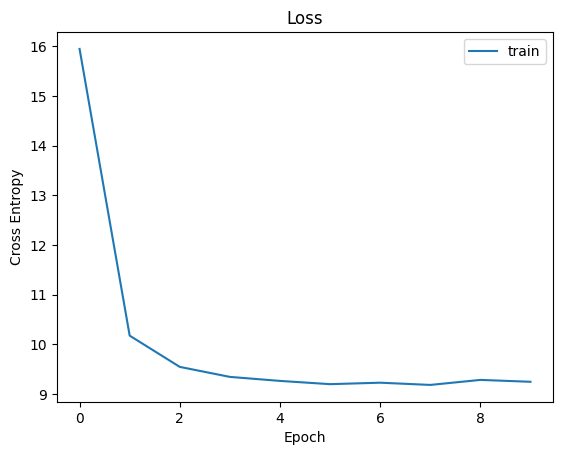

In [ ]:
hists = [hist1, hist2, hist3, hist4, hist5]
hist = hists[np.argmax(accuracies)] # take hist of best model

# plot
import matplotlib.pyplot as plt
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(hist1.history['loss'], label='train')
plt.legend()
plt.show()